In [78]:
import cv2
import random
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, regularizers
from tensorflow.keras.applications import EfficientNetV2S
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical, Sequence
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, roc_auc_score


In [3]:
import os
import pandas as pd


base  = "/kaggle/input/chest-x-ray-6-classes-dataset/chest-xray"
df = pd.DataFrame([
    {"path": os.path.join(base, split, label, img), "label": label}
    for split in ["train", "val"]
    for label in os.listdir(os.path.join(base, split))
    for img in os.listdir(os.path.join(base, split, label))
])

# sample max 300 per class
df_small = df.groupby("label").apply(lambda x: x.sample(n=min(300, len(x)), random_state=42)).reset_index(drop=True)

df_small.head()

print(df_small.head())
print(df_small.tail())


                                                path     label
0  /kaggle/input/chest-x-ray-6-classes-dataset/ch...  Covid-19
1  /kaggle/input/chest-x-ray-6-classes-dataset/ch...  Covid-19
2  /kaggle/input/chest-x-ray-6-classes-dataset/ch...  Covid-19
3  /kaggle/input/chest-x-ray-6-classes-dataset/ch...  Covid-19
4  /kaggle/input/chest-x-ray-6-classes-dataset/ch...  Covid-19
                                                   path         label
1795  /kaggle/input/chest-x-ray-6-classes-dataset/ch...  Tuberculosis
1796  /kaggle/input/chest-x-ray-6-classes-dataset/ch...  Tuberculosis
1797  /kaggle/input/chest-x-ray-6-classes-dataset/ch...  Tuberculosis
1798  /kaggle/input/chest-x-ray-6-classes-dataset/ch...  Tuberculosis
1799  /kaggle/input/chest-x-ray-6-classes-dataset/ch...  Tuberculosis


/tmp/ipykernel_36/2372917758.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_small = df.groupby("label").apply(lambda x: x.sample(n=min(300, len(x)), random_state=42)).reset_index(drop=True)


In [4]:
import numpy as np

def preprocess(path, size=224):
    img = cv2.imread(path)
    img = cv2.resize(img, (size, size))
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    cl = cv2.createCLAHE(2.0).apply(l)
    img = cv2.cvtColor(cv2.merge((cl, a, b)), cv2.COLOR_LAB2RGB)
    return img / 255.0


In [5]:
class XRayGen(Sequence):
    def __init__(self, df, batch=32):
        self.df = df.sample(frac=1).reset_index(drop=True)
        self.batch = batch

    def __len__(self): return len(self.df) // self.batch

    def __getitem__(self, i):
        batch = self.df.iloc[i*self.batch:(i+1)*self.batch]
        X = np.array([preprocess(p) for p in batch['path']])
        y = pd.get_dummies(batch['label']).values
        return X, y
        

In [6]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

def load_balanced_data(df, img_size=224, test_size=0.2):
    images, labels = [], []
    label_map = {label: idx for idx, label in enumerate(df['label'].unique())}

    for _, row in df.iterrows():
        img = preprocess(row['path'], size=img_size)
        images.append(img)
        labels.append(label_map[row['label']])

    X = np.array(images)
    y = to_categorical(np.array(labels), num_classes=len(label_map))

    return train_test_split(X, y, test_size=test_size, random_state=42)


In [7]:
X_train, X_val, y_train, y_val = load_balanced_data(df_small)

print("Train shape:", X_train.shape, y_train.shape)
print("Val shape:", X_val.shape, y_val.shape)


Train shape: (1440, 224, 224, 3) (1440, 6)
Val shape: (360, 224, 224, 3) (360, 6)


In [8]:
def build_model(img_size=224, num_classes=6):
    base_model = EfficientNetV2S(
        include_top=False,
        input_shape=(img_size, img_size, 3),
        weights="imagenet"
    )
    base_model.trainable = True  # Fine-tune all layers

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

In [9]:
model = build_model()

from tensorflow.keras.metrics import AUC

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        AUC(name='auc', multi_label=False)
    ]
)

I0000 00:00:1755852928.162028      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


82420632/82420632 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [10]:
early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1
)


In [11]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=16,
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/10


I0000 00:00:1755853046.214071     100 service.cc:148] XLA service 0x7dfbac003ef0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755853046.214804     100 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1755853056.457781     100 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1755853069.885387     100 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1755853070.072391     100 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1755853070.463617     100 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1755853070.6599

90/90 ━━━━━━━━━━━━━━━━━━━━ 203s 345ms/step - accuracy: 0.3917 - auc: 0.7538 - loss: 1.9150 - val_accuracy: 0.6361 - val_auc: 0.9235 - val_loss: 1.3286 - learning_rate: 1.0000e-04
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - accuracy: 0.7269 - auc: 0.9488 - loss: 0.9441 - val_accuracy: 0.7472 - val_auc: 0.9624 - val_loss: 0.9371 - learning_rate: 1.0000e-04
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - accuracy: 0.7975 - auc: 0.9655 - loss: 0.7936 - val_accuracy: 0.7750 - val_auc: 0.9689 - val_loss: 0.7930 - learning_rate: 1.0000e-04
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - accuracy: 0.8516 - auc: 0.9837 - loss: 0.6235 - val_accuracy: 0.7750 - val_auc: 0.9703 - val_loss: 0.7895 - learning_rate: 1.0000e-04
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - accuracy: 0.9023 - auc: 0.9893 - loss: 0.5315 - val_accuracy: 0.7917 - val_auc: 0.9653 - val_loss: 0.8582 - learning_rate: 1.0000e-04
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - accuracy: 

In [13]:
y_pred_probs = model.predict(X_val)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_val, axis=1)


12/12 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step


In [15]:
from sklearn.metrics import classification_report

labels = df_small['label'].unique()
label_map = {label: idx for idx, label in enumerate(labels)}
inv_label_map = {v: k for k, v in label_map.items()}

print(classification_report(y_true, y_pred, target_names=[inv_label_map[i] for i in range(len(inv_label_map))]))

                     precision    recall  f1-score   support

           Covid-19       0.86      0.83      0.85        53
          Emphysema       0.89      0.91      0.90        74
             Normal       0.89      0.93      0.91        55
Pneumonia-Bacterial       0.64      0.58      0.61        50
    Pneumonia-Viral       0.68      0.72      0.70        68
       Tuberculosis       1.00      1.00      1.00        60

           accuracy                           0.83       360
          macro avg       0.83      0.83      0.83       360
       weighted avg       0.83      0.83      0.83       360



In [23]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Predict on validation set

y_pred_probs = model.predict(X_val)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_val, axis=1)

# Accuracy & AUC
val_acc = accuracy_score(y_true, y_pred_classes)
val_auc = roc_auc_score(y_val, y_pred_probs, multi_class='ovr')

print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Validation AUC: {val_auc:.4f}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step
Validation Accuracy: 0.8333
Validation AUC: 0.9713


In [39]:
import os, random, cv2
import numpy as np

# Constants
IMG_SIZE = 224
CLASS_NAMES = ['Covid-19', 'Emphysema', 'Normal', 'Pneumonia-Bacterial', 'Pneumonia-Viral', 'Tuberculosis']
test_base = "/kaggle/input/chest-x-ray-6-classes-dataset/chest-xray/test"

# Preprocessing function
def preprocess_external_image(img_path, size=IMG_SIZE):
    img = cv2.imread(img_path)
    lab = cv2.cvtColor(cv2.resize(img, (size, size)), cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    cl = cv2.createCLAHE(2.0).apply(l)
    img = cv2.cvtColor(cv2.merge((cl, a, b)), cv2.COLOR_LAB2RGB)
    return np.expand_dims(img / 255.0, axis=0)

# Predict 5 random images
for _ in range(5):
    cls = random.choice(CLASS_NAMES)
    img_file = random.choice(os.listdir(os.path.join(test_base, cls)))
    path = os.path.join(test_base, cls, img_file)

    img_array = preprocess_external_image(path)
    pred = model.predict(img_array)[0]
    pred_label = CLASS_NAMES[np.argmax(pred)]

    print(f"\n🩻 Image: {img_file}")
    print(f"True Label     : {cls}")
    print(f"Predicted Label: {pred_label}")
    print("Confidence Scores:")
    for i, name in enumerate(CLASS_NAMES):
        print(f"{name}: {pred[i]:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step

🩻 Image: Pneumonia-Viral (1508).jpg
True Label     : Pneumonia-Viral
Predicted Label: Pneumonia-Bacterial
Confidence Scores:
Covid-19: 0.0000
Emphysema: 0.0000
Normal: 0.0000
Pneumonia-Bacterial: 0.9947
Pneumonia-Viral: 0.0052
Tuberculosis: 0.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step

🩻 Image: COVID-19 (1044).jpg
True Label     : Covid-19
Predicted Label: Emphysema
Confidence Scores:
Covid-19: 0.1549
Emphysema: 0.8218
Normal: 0.0000
Pneumonia-Bacterial: 0.0227
Pneumonia-Viral: 0.0005
Tuberculosis: 0.0001
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step

🩻 Image: Emphysema_2112.jpg
True Label     : Emphysema
Predicted Label: Emphysema
Confidence Scores:
Covid-19: 0.0015
Emphysema: 0.9970
Normal: 0.0000
Pneumonia-Bacterial: 0.0003
Pneumonia-Viral: 0.0001
Tuberculosis: 0.0012
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step

🩻 Image: Pneumonia-Viral (1069).jpg
True Label     : Pneumonia-Viral
Predicted Label: Pneumonia-Viral
Confidence Scores:
Covid-19: 0.0000
Emphysema:

In [42]:
model.save("xray_classifier_model.keras")


In [72]:
from tensorflow.keras.preprocessing.image import array_to_img

# Grad-CAM heatmap generator
def make_gradcam_heatmap(img_array, model, last_conv_layer_name="top_conv", pred_index=None):
    base_model = model.layers[0]  # EfficientNetV2S inside Sequential

    # Build a model that maps input to the last conv layer and base model output
    grad_model = tf.keras.models.Model(
        inputs=base_model.input,
        outputs=[base_model.get_layer(last_conv_layer_name).output, base_model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, base_predictions = grad_model(img_array)
        # Pass base model output through remaining layers of your Sequential model
        x = model.layers[1](base_predictions)
        x = model.layers[2](x)
        x = model.layers[3](x)
        x = model.layers[4](x)
        x = model.layers[5](x)
        predictions = model.layers[6](x)

        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


# Grad-CAM display function
def display_gradcam(img_array, heatmap, true_label, pred_label, alpha=0.4):
    import matplotlib.cm as cm
    from tensorflow.keras.preprocessing.image import array_to_img

    # Rescale heatmap
    heatmap = np.uint8(255 * heatmap)
    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Resize and convert to image
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img_array.shape[1], img_array.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose
    superimposed_img = jet_heatmap * alpha + img_array * 255.0
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    # Display
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title(f"Original Image\nTrue Label: {true_label}")
    plt.imshow(array_to_img(img_array))
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title(f"Grad-CAM Overlay\nPredicted: {pred_label}")
    plt.imshow(superimposed_img)
    plt.axis("off")
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


/tmp/ipykernel_36/1969538566.py:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


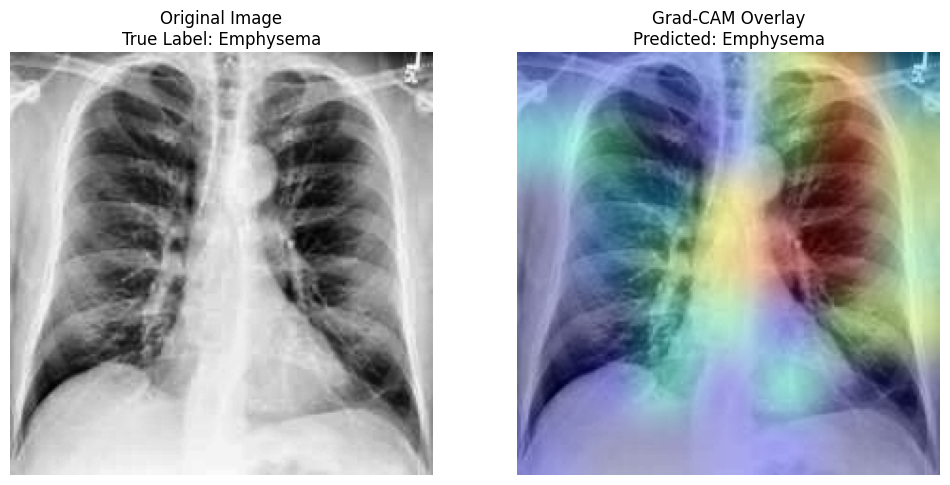

In [75]:
# Pick a random test image
cls = random.choice(CLASS_NAMES)
img_file = random.choice(os.listdir(os.path.join(test_base, cls)))
img_path = os.path.join(test_base, cls, img_file)

# Preprocess and predict
img_array = preprocess_external_image(img_path)
pred_probs = model.predict(img_array)[0]
pred_label = CLASS_NAMES[np.argmax(pred_probs)]

# Generate Grad-CAM
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name="top_conv")

# Display with labels
display_gradcam(img_array[0], heatmap, true_label=cls, pred_label=pred_label)


In [76]:
model.save("xray_classifier_model.keras")
